## Stable Diffusion fine tune with DreamBooth on SageMaker notebook
* Tested with ml.g5.2xlarge SageMaker notebook, which has a NVIDIA A10G GPU with 24 GiB GPU memory.
* Content included training part and inference part.
* If you tend to optimize GPU with less memory used, refer to [ShivamShrirao's repo](https://github.com/ShivamShrirao/diffusers/tree/main/examples/dreambooth)
* Major training codes were borrowed from [Huggingface's repo](https://github.com/huggingface/diffusers/tree/main/examples/dreambooth) and most of inference codes were borrowed from [Philschmid's blog](https://www.philschmid.de/sagemaker-stable-diffusion).

## Prerequisites:
* Due to the kernel of notebook instance has been updated recently(3.8->3.9), there are some inconsistencies for several lib packages. Below is temporary workaround to fix bugs. And it will be removed once AWS fix the issue formally.

In [ ]:
!pip install -U boto3
!pip install -U sagemaker
!pip install ipywidgets==7.7.2 

In [ ]:
# restart kernel to avoid error like "UnknownServiceError: Unknown service: 'sagemaker'", and inconsistency of ipywidgets

import os
os._exit(00)

## 1. SageMaker training part

### 1.1 Install dependencies

In [ ]:
!pip install -U pip
!pip install -U torch==1.13.1+cu117 -f https://download.pytorch.org/whl/torch_stable.html
!pip install git+https://github.com/huggingface/diffusers.git

In [ ]:
%%writefile requirements.txt
accelerate
torchvision
transformers>=4.25.1
ftfy
tensorboard
modelcards
bitsandbytes==0.35.4  # newly updated version of bitsandbytes made images into garbage, so freeze the version for now
datasets  # huggingface diffusers repo's bug for missing implementation of datasets

In [ ]:
!pip install -U -r requirements.txt

### 1.2 Initialize an Accelerate environment 

In [ ]:
from accelerate.utils import write_basic_config
write_basic_config()

### 1.3 Get training scripts from HuggingFace Diffusers repo

In [5]:
!wget -q https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth.py

### 1.4 Train a modle for generating NIKKE Anis images
* "Person(avatar)" training example, you can also train the model for "style" or "object"  
* More information you can refer to [DreamBooth example of Huggingface Diffusers](https://github.com/huggingface/diffusers/tree/main/examples/dreambooth)

In [6]:
MODEL_NAME = "runwayml/stable-diffusion-v1-5" 
OUTPUT_DIR = "stable_diffusion_weights/dreambooth_fine_tune"
INSTANCE_DATA_DIR = "images/tuk/source"
CLASS_DATA_DIR = "images/tuk/class"
IMAGES_OUTPTS = "images/outputs"
!mkdir -p $OUTPUT_DIR $INSTANCE_DATA_DIR $CLASS_DATA_DIR $IMAGES_OUTPTS

In [ ]:
!git clone https://github.com/terrificdm/dreambooth-stablediffusion-sagemaker-notebook
!cp -r dreambooth-stablediffusion-sagemaker-notebook/images/tuk/source/* $INSTANCE_DATA_DIR
# you can generate your own class images during training
!cp -r dreambooth-stablediffusion-sagemaker-notebook/images/tuk/class/* $CLASS_DATA_DIR 

In [8]:
# Due to SageMaker upgrade notebook kernel recently, you might encounter error like "ImportError: /lib64/libstdc++.so.6: version `GLIBCXX_3.4.26' not found", use below scripts to avoid
!sudo rm -rf /lib64/libstdc++.so.6 /lib64/libstdc++.so.6
!sudo ln -s /home/ec2-user/anaconda3/envs/python3/lib/libstdc++.so.6 /lib64/libstdc++.so.6

In [ ]:
!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME  \
  --instance_data_dir=$INSTANCE_DATA_DIR \
  --class_data_dir=$CLASS_DATA_DIR \
  --output_dir=$OUTPUT_DIR \
  --train_text_encoder \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --instance_prompt="photo of avdtuk avatar girl" \
  --class_prompt="photo of avatar girl" \
  --resolution=512 \
  --train_batch_size=1 \
  --use_8bit_adam \
  --gradient_checkpointing \
  --learning_rate=1e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=200 \
  --max_train_steps=1000

### 1.5 Mode inference testing

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

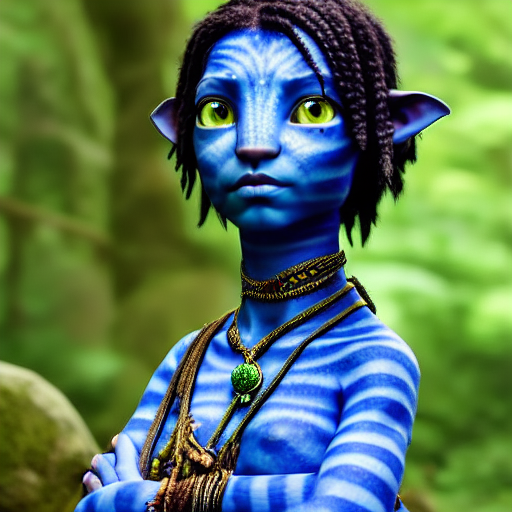

images/outputs/7844893340899879_2023-02-11 14:49:50.png



  0%|          | 0/20 [00:00<?, ?it/s]

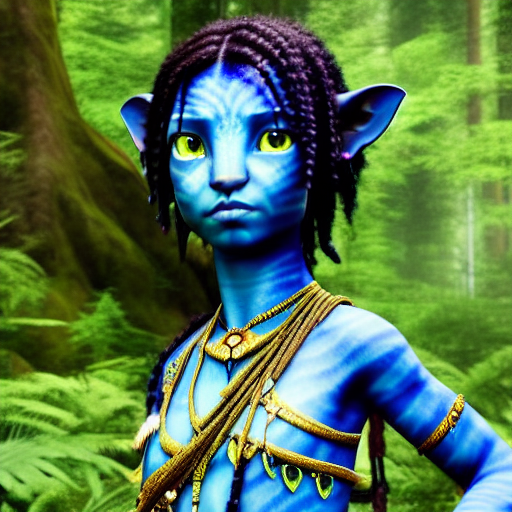

images/outputs/3213490040054872_2023-02-11 14:49:52.png


Seeds for generating images: [7844893340899879, 3213490040054872]



In [10]:
import torch
import datetime

from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler
model_dir = OUTPUT_DIR

scheduler = EulerAncestralDiscreteScheduler.from_pretrained(model_dir, subfolder="scheduler")
generator = torch.Generator(device="cuda")
pipe = StableDiffusionPipeline.from_pretrained(model_dir, scheduler=scheduler, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

# Uncomment below codes, if you don't want to enable NFSW
# def dummy(images, **kwargs):
#     return images, False
# pipe.safety_checker = dummy

prompt = "photo of avdtuk avatar girl, nice detailed face, blue skin, forest background, masterpiece, best quality, highly detailed"
negative_prompt = "lowres, worst quality, ugly, (disfigured), ((mutated hands, misshapen hands, mutated fingers, fused fingers):1.2), extra limbs, deformed legs, disfigured legs, text, logo, watermark"

num_images = 2
seeds = []
for _ in range(num_images):
    seed = generator.seed()
    seeds.append(seed)
    generator = generator.manual_seed(seed)
    image = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        height=512,
        width=512,
        num_images_per_prompt=1,
        num_inference_steps=20,
        guidance_scale=7.5,
        generator = generator
    ).images[0]
    display(image)
    now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    file_path = IMAGES_OUTPTS + "/" + str(seed) + "_" + str(now) + ".png"
    print(file_path + "\n")
    image.save(file_path)
    
# print(seeds)
print(f"\nSeeds for generating images: {seeds}\n")

  0%|          | 0/20 [00:00<?, ?it/s]

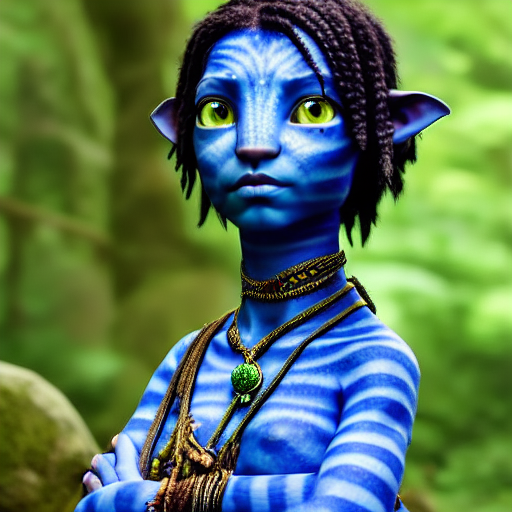

In [11]:
# Comment below codes, if you don't want to produce the same images again
seed = seeds[0] # use the first seed
generator.manual_seed(seed)
image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    height=512,
    width=512,
    num_images_per_prompt=1,
    num_inference_steps=20,
    guidance_scale=7.5,
    generator = generator
).images[0]
display(image)

### 1.6 Use scripts to convert weights to ckpt to use in web UIs like AUTOMATIC1111
* For how to use "Stable Diffusion web UI" of AUTOMATIC1111, please refer to this repo
* DreamBooth plugin can also be implemented for "Stable Diffusion web UI" to fine tune the model
* You can also use other methods provided by webUI to fine tune the model.

In [12]:
# !wget -q https://raw.githubusercontent.com/huggingface/diffusers/main/scripts/convert_diffusers_to_original_stable_diffusion.py
# ckpt_path = OUTPUT_DIR + "/model.ckpt"
# half_arg = ""
# # Whether to convert to fp16, takes half the space (2GB).
# fp16 = False # {type: "boolean"}
# if fp16:
#     half_arg = "--half"
# !python convert_diffusers_to_original_stable_diffusion.py --model_path $OUTPUT_DIR  --checkpoint_path $ckpt_path $half_arg
# print(f"[*] Converted ckpt saved at {ckpt_path}")

## 2. SageMaker inference part

### 2.1 Initialize SageMaker inference endpoint

In [ ]:
import boto3
import sagemaker

sess = sagemaker.Session()
sagemaker_session_bucket=None

if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()
    
try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")

### 2.2 Create "inference.py" script for SageMaker

In [14]:
!mkdir $OUTPUT_DIR/code

In [ ]:
%%writefile $OUTPUT_DIR/code/requirements.txt
diffusers
transformers>=4.25.1

In [ ]:
%%writefile $OUTPUT_DIR/code/inference.py
import base64
import torch
from io import BytesIO
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler


def model_fn(model_dir):
    
    # Load stable diffusion and move it to the GPU
    scheduler = EulerAncestralDiscreteScheduler.from_pretrained(model_dir, subfolder="scheduler")
    pipe = StableDiffusionPipeline.from_pretrained(model_dir, scheduler=scheduler, torch_dtype=torch.float16)
    pipe = pipe.to("cuda")

    return pipe


def encoded_image(generator, seed, pipe, prompt, negative_prompt, height, width, num_inference_steps, guidance_scale):
    
    generator = generator.manual_seed(seed)
    generated_images = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        height=height,
        width=width,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator = generator
    )["images"][0]
    buffered = BytesIO()
    generated_images.save(buffered, format="PNG")
    encoded_image_response = base64.b64encode(buffered.getvalue()).decode()
    
    return encoded_image_response


def predict_fn(data, pipe):
    
    generator = torch.Generator(device="cuda")
    
    # get prompt & parameters
    prompt = data.pop("prompt", "")
    negative_prompt = data.pop("negative_prompt", "")
    # set valid HP for stable diffusion
    height = data.pop("height", 512)
    width = data.pop("width", 512)
    num_inference_steps = data.pop("num_inference_steps", 20)
    guidance_scale = data.pop("guidance_scale", 7.5)
    num_images_per_prompt = data.pop("num_images_per_prompt", 2)
    seed = data.pop("seed", "")
    
    seeds = []
    encoded_images = []
    
    # run generation with parameters
    if seed:
        seeds.append(seed)
        encoded_image_rt = encoded_image(generator, seed, pipe, prompt, negative_prompt, height, width, num_inference_steps, guidance_scale)
        encoded_images.append(encoded_image_rt)
        for _ in range(num_images_per_prompt-1):
            seed=seed+1
            seeds.append(seed)
            encoded_image_rt = encoded_image(generator, seed, pipe, prompt, negative_prompt, height, width, num_inference_steps, guidance_scale)
            encoded_images.append(encoded_image_rt)
    else:
        for _ in range(num_images_per_prompt):
            seed = generator.seed()
            seeds.append(seed)
            encoded_image_rt = encoded_image(generator, seed, pipe, prompt, negative_prompt, height, width, num_inference_steps, guidance_scale)
            encoded_images.append(encoded_image_rt)

    # create response
    return {"generated_images": encoded_images, "seeds": seeds}

### 2.3 Package SageMaker model.tar.gz artifact

In [ ]:
!tar --exclude checkpoint-1000 --exclude checkpoint-500 --exclude logs --use-compress-program=pigz -pcvf $OUTPUT_DIR/model.tar.gz -C $OUTPUT_DIR/ .

### 2.4 Upload the model to S3 bucket

In [18]:
from sagemaker.s3 import S3Uploader
s3_model_uri=S3Uploader.upload(local_path=f"{OUTPUT_DIR}/model.tar.gz", desired_s3_uri=f"s3://{sess.default_bucket()}/stablediffusion-dreambooth/g5")

### 2.5 Deploy the model to SageMaker

In [ ]:
from sagemaker.huggingface.model import HuggingFaceModel

# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
   model_data=s3_model_uri,      # path to your model and script
   role=role,                    # iam role with permissions to create an Endpoint
   transformers_version="4.17",  # transformers version used
   pytorch_version="1.10",       # pytorch version used
   py_version='py38',            # python version used
)

# deploy the endpoint
predictor = huggingface_model.deploy(
    initial_instance_count=1,
    instance_type="ml.g5.2xlarge"
    )

### 2.6 Generate images using SageMaker inference endpoint

In [20]:
from PIL import Image
from io import BytesIO
import base64
import datetime

# helper decoder
def decode_base64_image(image_string):
    base64_image = base64.b64decode(image_string)
    buffer = BytesIO(base64_image)
    return Image.open(buffer)

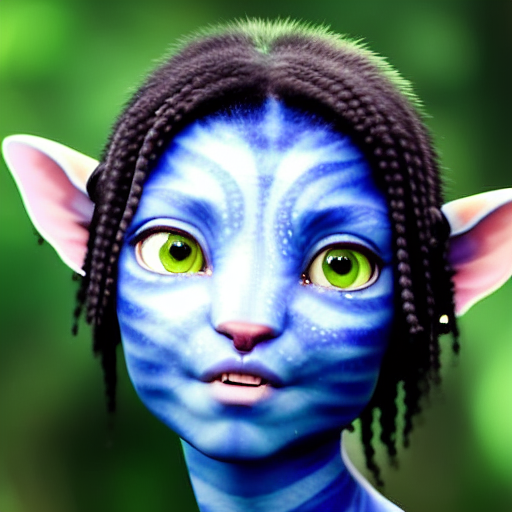

images/outputs/2266886858023473_2023-02-11 15:12:58.577191.png



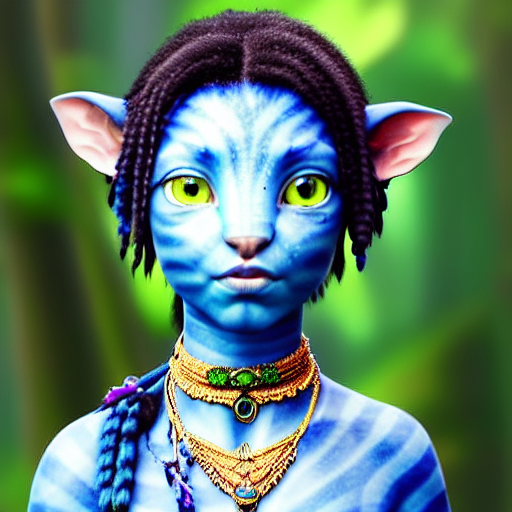

images/outputs/5969242726612513_2023-02-11 15:12:59.238531.png


Seeds for generating images: [2266886858023473, 5969242726612513]

Images saved in: s3://sagemaker-us-east-1-091166060467/stablediffusion-dreambooth/g4dn/images_output



In [25]:
#run prediction
response = predictor.predict(data={
    "prompt": "photo of avdtuk avatar girl, nice detailed face, blue skin, forest background, masterpiece, best quality, highly detailed",
    "negative_prompt": "lowres, worst quality, ugly, (disfigured), ((mutated hands, misshapen hands, mutated fingers, fused fingers):1.2), extra limbs, deformed legs, disfigured legs, text, logo, watermark",
    "height": 512,
    "width": 512,
    "num_images_per_prompt":2,
    # "seed" : 3904759173130859  # uncomment seed and replace with generated one, if you want to produce same
  }
)

#decode images
decoded_images = [decode_base64_image(image) for image in response["generated_images"]]

#visualize generation
i = 0
for image in decoded_images:
    display(image)
    seed = response['seeds'][i]
    i = i+1
    now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")
    file_path = IMAGES_OUTPTS + "/" + str(seed) + "_" + str(now) + ".png"
    print(file_path + "\n")
    image.save(file_path)
    # comment below code if you don't want to save in S3 bucket
    S3Uploader.upload(local_path=file_path, desired_s3_uri=f"s3://{sess.default_bucket()}/stablediffusion-dreambooth/g5/images_output")
    
# print(seeds)
print(f"\nSeeds for generating images: {response['seeds']}")
print(f"\nImages saved in: " + f"s3://{sess.default_bucket()}/stablediffusion-dreambooth/g4dn/images_output\n")

### 2.7 Delete model and endpoint

In [26]:
# uncomment below codes if you wanto to delete mode and endpoint for inference
# predictor.delete_model()
# predictor.delete_endpoint()